# What can we find out from our data?

### From our sampling of 498 jobs on Indeed.co.uk, what potential trends or insights can we glean from the Software Developer (SE) job market? 

Here are our questions that we'll be posing to the data:
1. How many SE jobs advertise salary?
2. What is the spread of salaries advertised for SE jobs on indeed.co.uk?
3. What are the main locations that SE appear in, other than London?
4. What are some of the most frequent words mentioned in the job title?
5. Which programming languages are in greatest demand?
6. What are the main topics emerging from the job descriptions and the title?

> ### P P D A C - Problem, Plan, Data, Analysis, Conclusion

* **Problem** - we have our questions about the software developer UK market
* **Plan** - scrape data from Indeed.co.uk using BS4 and Selenium; Extract key info using regex; plot data using Seaborn; carry out statistical tests (Point Biserial Coef.); Use LDA to look for latent topics in job descriptions.
* **Data** - Webscrapped job descriptions from Indeed.co.uk, searched for on the morning of 20th November, 2020. 500 Jobs originally stored. 2 were found to be unusable / duplicated. Thus I have 498 job descriptions, of which 243 actually state salary.
* **Analysis** - Barplots and boxplots illustrate salary distributions for London and non-London jobs. With an $\alpha$ of 0.05 (corrected to 0.01 for proposed number of statistical tests), I set out to test if mentions of certain programming languages correlated with salaries. Tested for outliers, normality and equal variance amongst subgroups. Failed to reject null hypothesis for any language group. For topic modelling, detected a few emergent themes. 
* **Conclusion**

1. Just over half of SE jobs do **not** advertise salary openly. 
2. The median job salary is £45k. The London median is 58K (mean of ~ 60k).
3. Twice as many posted jobs are non-London than based in the capital. These jobs are however extremely spread out amongst many different locations. Cambridge, Reading, Birmingham and Oxford are the following cities in terms of number of jobs posted.
4. Less than 1 in 10 jobs are advertising with a programming language directly in their title (e.g. "Python developer"). About 10-20% of roles advertise with level of seniority directly in the title ("senior" vs "junior") and less than 10% directly require a university graduate (at least, going by title). 
5. The 3 languages in greatest demand (both in terms of overall, total frequency - i.e. counting two mentions in one post as two - as single mentions) are JavaScript (and variants such as CoffeeScript and TypeScript), Python and Java. 
6. Amongst the few emergent themes, there appear to be the following themes:
    i. Academic / scientific posts - for devs working for research organisations such as Oxford Nanopores Technology or Siemens Digital Industries. 
    ii. Finance - SE roles focussed on building and optimising software for banks and for trading. Think London Stock Exchange (yes, one of their jobs is included here).
    iii. Architecture and computing - SE roles centred around computer architecture or cluster computing - think (Apache) Spark, arm, cluster computing. 

In [1]:
# Load the data and libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import functions as fn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
import pyLDAvis.sklearn
import topic_mod as topic

sns.set_style('darkgrid')

df = pd.read_csv('clean_data/final_SE_jobs_clean.csv', index_col=0);
df.info();

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 0 to 499
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   company                              498 non-null    object 
 1   job_title                            498 non-null    object 
 2   job_descr                            498 non-null    object 
 3   time_of_scrape                       498 non-null    object 
 4   job_search_term                      498 non-null    object 
 5   salary_from_page_source_as_stated    243 non-null    float64
 6   salary_from_page_source_conv_hourly  243 non-null    float64
 7   salary_from_page_source_time_period  243 non-null    object 
 8   Num_reviews                          238 non-null    float64
 9   Loc_from_title                       498 non-null    object 
 10  date                                 498 non-null    object 
dtypes: float64(3), object(8)
memory 

## 1. How many SE jobs advertise salary?
There's almost an even split of jobs that advertised salary vs those that didn't. Although this is far from perfect, it's a much better picture than for Data Scientists and Data Analysts (see my other indeed scraping project). 
#### Why is this important?
Developers deserve to know what they're worth, in concrete terms. If you're offering your skills on the market, to be able to compare between different employers, you will almost certainly be swayed by salaries, even if they're just ranges. It also matters in order for people to be payed fairly that salaries are declared upfront. Getting hired is a two-way street between the employer and employee - both have to convince the other that they're worthwhile. 

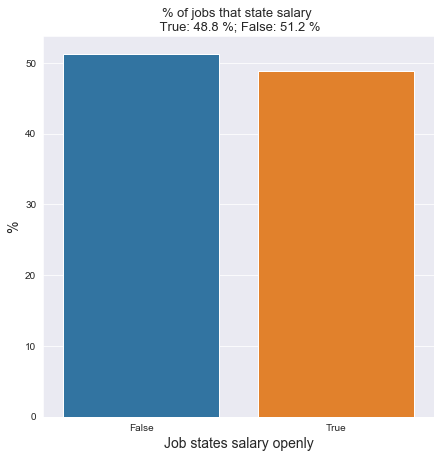

In [2]:
plt.figure(figsize=(7,7))
df['states_salary'] = ~df.salary_from_page_source_as_stated.isna()
g=df.groupby('states_salary').size().reset_index()
g.iloc[:,1] = round(g.iloc[:, 1]/len(df) * 100, 2)
plt.title(f'% of jobs that state salary \n True: {g.iloc[1,1]} %; False: {g.iloc[0,1]} %' , 
          fontdict={'size':13})
sns.barplot(data=g, x='states_salary', y=g.iloc[:,1],)
plt.xlabel('Job states salary openly', fontdict={'size':14})
plt.ylabel('%', fontdict={'size':14,},)
plt.savefig('fig/percent_jobs_state_salary.jpg')
plt.show()

## 2. What is the spread of salaries advertised for SE jobs on indeed.co.uk?
If we first look at how jobs are reported (i.e. yearly, daily, monthly, weekly), we can see that the vast majority are annual. Discarding the 2 outliers that are weekly and monthly, we plot them further below. It would not be robust decision to infer *anything* of significance about the group of weekly salaries (since there's only 9 of them!), however, this picture does fit well with the notion that short-term contracts, paying per day or per hour tend to pay higher. However, note that:
* those contracts often lack things such as health insurace, sick pay and the other important features of a worthwhile contract;
* at least 5 of the outliers from the annual reported salaries match the dailies in hourly rates. 

In [3]:
salaries_df = df.loc[~df.salary_from_page_source_as_stated.isna()]
salaries_df.salary_from_page_source_time_period.value_counts()

Y    232
D      9
M      1
W      1
Name: salary_from_page_source_time_period, dtype: int64

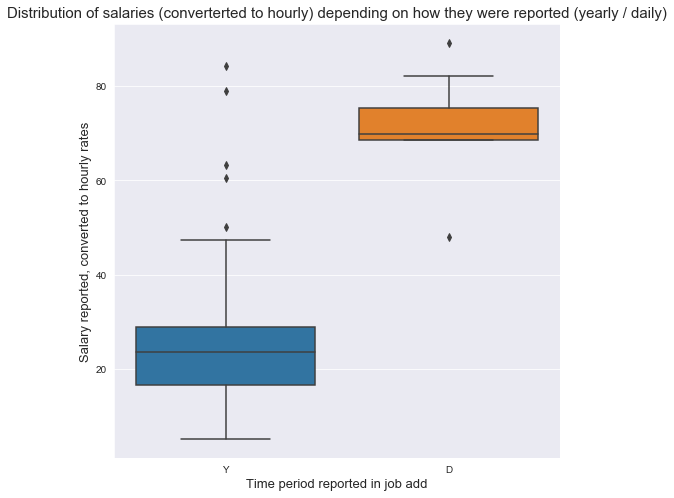

In [4]:
Y_and_D_salaries = salaries_df.loc[((salaries_df.salary_from_page_source_time_period=='Y') ^ (salaries_df.salary_from_page_source_time_period=='D')) ]

plt.figure(figsize=(8,8))

plt.title('Distribution of salaries (converterted to hourly) depending on how they were reported (yearly / daily)', fontdict={'size':15})
ax = sns.boxplot(data = Y_and_D_salaries, y  = 'salary_from_page_source_conv_hourly' ,  x = 'salary_from_page_source_time_period',)
plt.xlabel('Time period reported in job add', fontdict={'size':13})
plt.ylabel('Salary reported, converted to hourly rates', fontdict={'size':13})
plt.show()

So amongst 232 salaries the median is £45k - not bad! We'll break this down further by region as well (since the location will have an impact due to the London allowance), but this is our baseline answer. Most jobs seem to gravitate in that range between 

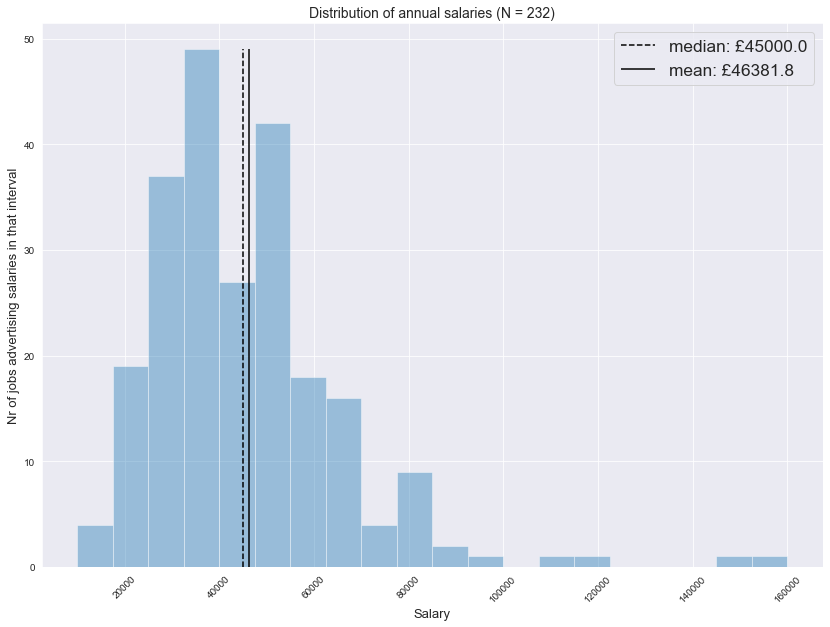

In [5]:
annual_pay = salaries_df.loc[salaries_df.salary_from_page_source_time_period=='Y']

plt.figure(figsize=(14,10))
ax = sns.distplot(annual_pay.salary_from_page_source_as_stated, kde=False, norm_hist=False)
plt.title('Distribution of annual salaries (N = 232)', fontdict={'size': 14})
plt.xlabel('Salary', fontdict={'size':13})
plt.ylabel('Nr of jobs advertising salaries in that interval', fontdict={'size':13})
plt.xticks(rotation=45)
median = annual_pay.salary_from_page_source_as_stated.median().round(1)
mean = annual_pay.salary_from_page_source_as_stated.mean().round(1)
plt.vlines(x = median, ymin=0, ymax=49, linestyles='dashed', label=f'median: £{median}')
plt.vlines(x = mean, ymin=0, ymax=49, linestyles='solid', label=f'mean: £{mean}')
plt.legend(fontsize='xx-large')
plt.savefig('fig/dist_annual_salaries.jpg')
plt.show()

## 3. What are the main locations that SE appear in (other than London) and how does salary vary across them?

Our scraping retrieved 162 different locations, yet it's a very skewed distribution, what with 154 jobs being in London. The vast majority of locations have 1 job post associated with them (e.g. Milton Keynes, Morley). Note that although there are 13 jobs put down as Home-based, currently a lot of jobs in the data are "remote" or at least "temporarily remote" so that figure isn't something to use to judge remote working by. Also, there are 7 jobs where the location is "United Kingdom", which can be interpreted as null value for location. 

In [6]:
# a little bit of additional cleaning to put jobs that posted locs such as "East London" under the "London category"
df.Loc_from_title = df.Loc_from_title.apply(fn.is_london)
loc_df = df[['salary_from_page_source_as_stated', 'salary_from_page_source_time_period','job_title', 'Loc_from_title']]
loc_df = loc_df.groupby(['Loc_from_title']).size().sort_values(ascending=False)
loc_df[:10]

Loc_from_title
London        154
Cambridge      19
Reading        14
Home Based     13
Birmingham     12
Oxford         11
Manchester     11
Bristol         9
Leeds           8
Belfast         7
dtype: int64

* As expected the majority of jobs put London as their location, reflecting the concentration of demand for tech skills in the capital.
* Other predictable locations are Cambridge and Oxford, the former more notably so for being a bit of tech magnet. Even so, the numbers are dwarfed by London

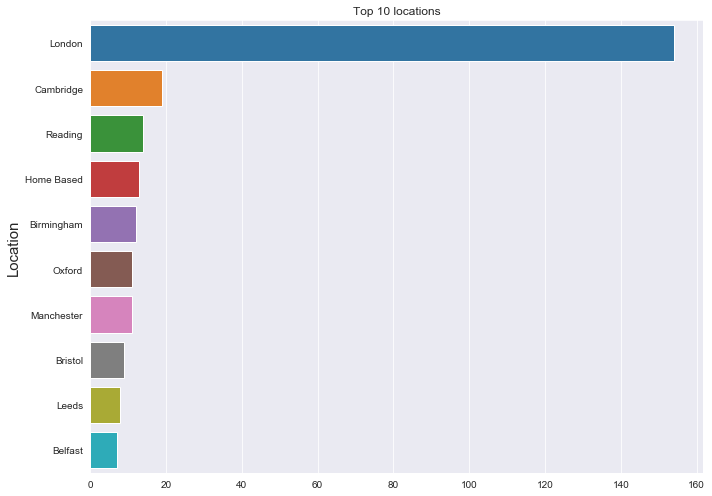

In [7]:
#plotting the nr of jobs by location stated
loc_df = df[['salary_from_page_source_as_stated', 'salary_from_page_source_time_period','job_title', 'Loc_from_title']]
loc_df_gr = loc_df.groupby(['Loc_from_title']).size().sort_values(ascending=False)
top_10 = loc_df_gr[:10]
plt.figure(figsize=(10,7))
sns.barplot(y=top_10.index, x=top_10);
plt.title('Top 10 locations')
plt.ylabel('Location', fontdict={'size':15})
plt.tight_layout()
plt.savefig('fig/top_10_locs.jpg')
plt.show()

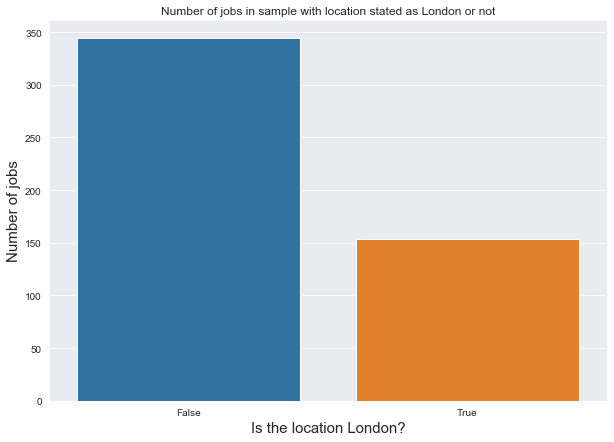

In [8]:
#plotting the nr of jobs by location London vs non-London
loc_df['is_london'] = False
loc_df.loc[loc_df.Loc_from_title =='London' , 'is_london'] = True
is_london_val = loc_df.is_london.value_counts()
plt.figure(figsize=(10,7))
sns.barplot(x=is_london_val.index, y=is_london_val.values);
plt.title('Number of jobs in sample with location stated as London or not')
plt.ylabel('Number of jobs', fontdict={'size':15})
plt.xlabel('Is the location London?', fontdict={'size':15})
plt.savefig('fig/ldn_vs_non_ldn.jpg')
plt.show()

In [9]:
sector_avg = pd.read_csv('clean_data/national_2019_62_avg.csv', index_col=0)
sector_avg

,AveragesAndPercentiles,2019
StandardIndustrialClassification,,
"62 : Computer Programming, Consultancy and Related Activities",Mean,43558.416667
"62 : Computer Programming, Consultancy and Related Activities",Median,37484.909091


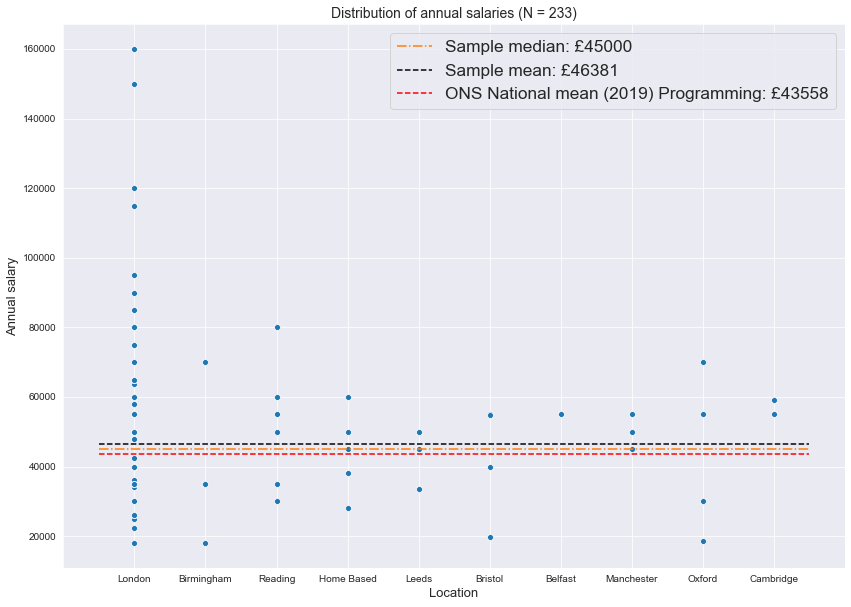

In [10]:
plt.figure(figsize=(14,10))
ax = sns.scatterplot(data = annual_pay.loc[annual_pay.Loc_from_title.isin(top_10.index)], y ='salary_from_page_source_as_stated', x='Loc_from_title',)
plt.title('Distribution of annual salaries (N = 233)', fontdict={'size': 14})
plt.xlabel('Location', fontdict={'size':13})
plt.ylabel('Annual salary', fontdict={'size':13})
sample_median = int(annual_pay.salary_from_page_source_as_stated.median())
sample_mean = int(annual_pay.salary_from_page_source_as_stated.mean())
ONS_mean_subsect62 = int(sector_avg['2019'][0])
plt.hlines(y = sample_median, xmin=-0.5, xmax=9.5 ,linestyles='dashdot', colors='C1' ,label=f'Sample median: £{sample_median}')
plt.hlines(y = sample_mean, xmin=-0.5, xmax=9.5 ,linestyles='dashed', label=f'Sample mean: £{sample_mean}')
plt.hlines(y = ONS_mean_subsect62, xmin=-0.5, xmax=9.5 ,linestyles='dashed', colors='r', label=f'ONS National mean (2019) Programming: £{ONS_mean_subsect62}')
plt.legend(fontsize='xx-large')
plt.savefig('fig/dist_annual_salaries_by_loc.jpg')
plt.show()

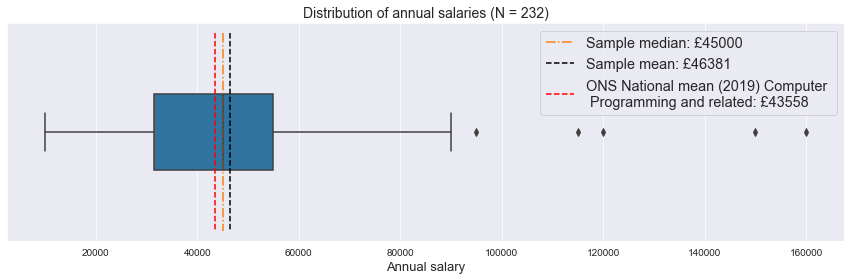

In [11]:
plt.figure(figsize=(15,4))
ax = sns.boxplot(data = annual_pay, x ='salary_from_page_source_as_stated', color='C0')
plt.title('Distribution of annual salaries (N = 232)', fontdict={'size': 14})
plt.xlabel('Annual salary', fontdict={'size':13})
sample_median = int(annual_pay.salary_from_page_source_as_stated.median())
sample_mean = int(annual_pay.salary_from_page_source_as_stated.mean())
ONS_mean_subsect62 = int(sector_avg['2019'][0])
plt.vlines(x = sample_median, ymin=-1.05, ymax=1.05 ,linestyles='dashdot', colors='C1' ,label=f'Sample median: £{sample_median}')
plt.vlines(x = sample_mean, ymin=-1.05, ymax=1.05,linestyles='dashed', label=f'Sample mean: £{sample_mean}')
plt.vlines(x = ONS_mean_subsect62, ymin=-1.05, ymax=1.05 ,linestyles='dashed', colors='r', label=f'ONS National mean (2019) Computer \n Programming and related: £{ONS_mean_subsect62}')
plt.legend(fontsize='x-large', loc='upper right', )
plt.savefig('fig/distribution_annual.jpg')
plt.show()

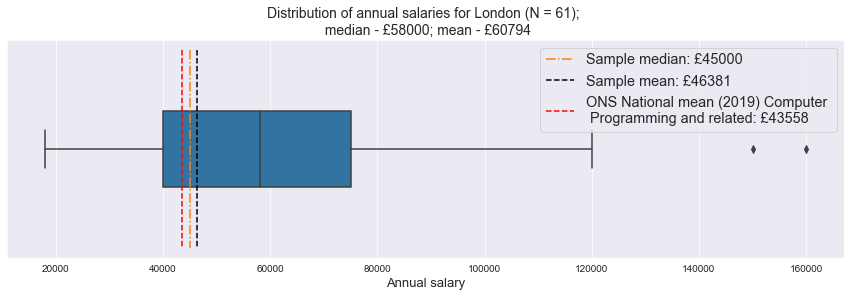

In [12]:
plt.figure(figsize=(15,4))
ldn_annual = annual_pay.loc[annual_pay.Loc_from_title=='London']
ax = sns.boxplot(data = ldn_annual, x ='salary_from_page_source_as_stated', color='C0')
plt.title(f'Distribution of annual salaries for London (N = 61); \n median - £{int(ldn_annual.salary_from_page_source_as_stated.median())}; mean - £{int(ldn_annual.salary_from_page_source_as_stated.mean())}', fontdict={'size': 14})
plt.xlabel('Annual salary', fontdict={'size':13})
sample_median = int(annual_pay.salary_from_page_source_as_stated.median())
sample_mean = int(annual_pay.salary_from_page_source_as_stated.mean())
ONS_mean_subsect62 = int(sector_avg['2019'][0])
plt.vlines(x = sample_median, ymin=-1.05, ymax=1.05 ,linestyles='dashdot', colors='C1' ,label=f'Sample median: £{sample_median}')
plt.vlines(x = sample_mean, ymin=-1.05, ymax=1.05,linestyles='dashed', label=f'Sample mean: £{sample_mean}')
plt.vlines(x = ONS_mean_subsect62, ymin=-1.05, ymax=1.05 ,linestyles='dashed', colors='r', label=f'ONS National mean (2019) Computer \n Programming and related: £{ONS_mean_subsect62}')
plt.legend(fontsize='x-large', loc='upper right', )
plt.savefig('fig/distribution_annual_London.jpg')
plt.show()

## 4. What are some of the most frequent words mentioned in the job titles?

When we look at the top 20 terms and 20 bigrams (pairs of words) that appear across all the titles (499 titles), what do we see? This can give us a quick indication of where the actual market is needing developers and what skills they have to focus on.
**Insights**
* Most frequent single term is 'senior' telling us that there is a significant demand for Senior developers, since over 50 job titles mention it - yet this is a small amount compared to the total number of jobs (499) - about 10% of jobs
* There's more senior roles being advertised than ostensibly 'junior' roles (~35), *unless* you count 'graduate' roles as being junior: i.e. if you're a junior, graduate developer, you have a wider pool of jobs to apply to
* **Languages** - Java, Python and PHP are the lead languages in demand across this sample, but the number of jobs advertising directly for a developer specialising in one programming language is quite small - at least going by title it would be less than 1 in 10. The picture will be different when looking at the job description fully, BUT what employers choose to place in the title of a role is important! Employers are incentivised to try to catch the right kind of attention - to minimize the number of people applying for unsuitable roles and the amount of suitable candidates applying for *their* positions. An employer titling a post with "*Python* developer" really prioritizes Python above a lot of other employee skills or coding languages and is not going to accept substitutes. 
* There aren't any significantly frequent bigrams, except for the coveted 'full stack' positions, which only appears in about 3% of the jobs. 

In [13]:
%%capture
#How many terms to include
N=20

# putting software and developer into the list of stopwords - words we wish to ignore
title_sw = fn.gen_stopwords(['software', 'developer'])
titles = df.job_title
title_df = fn.get_top_n_terms(titles, N, stop_words_list=title_sw)
title_df_bigram = fn.get_top_n_terms(titles, N, stop_words_list=title_sw , ngram_number=2)

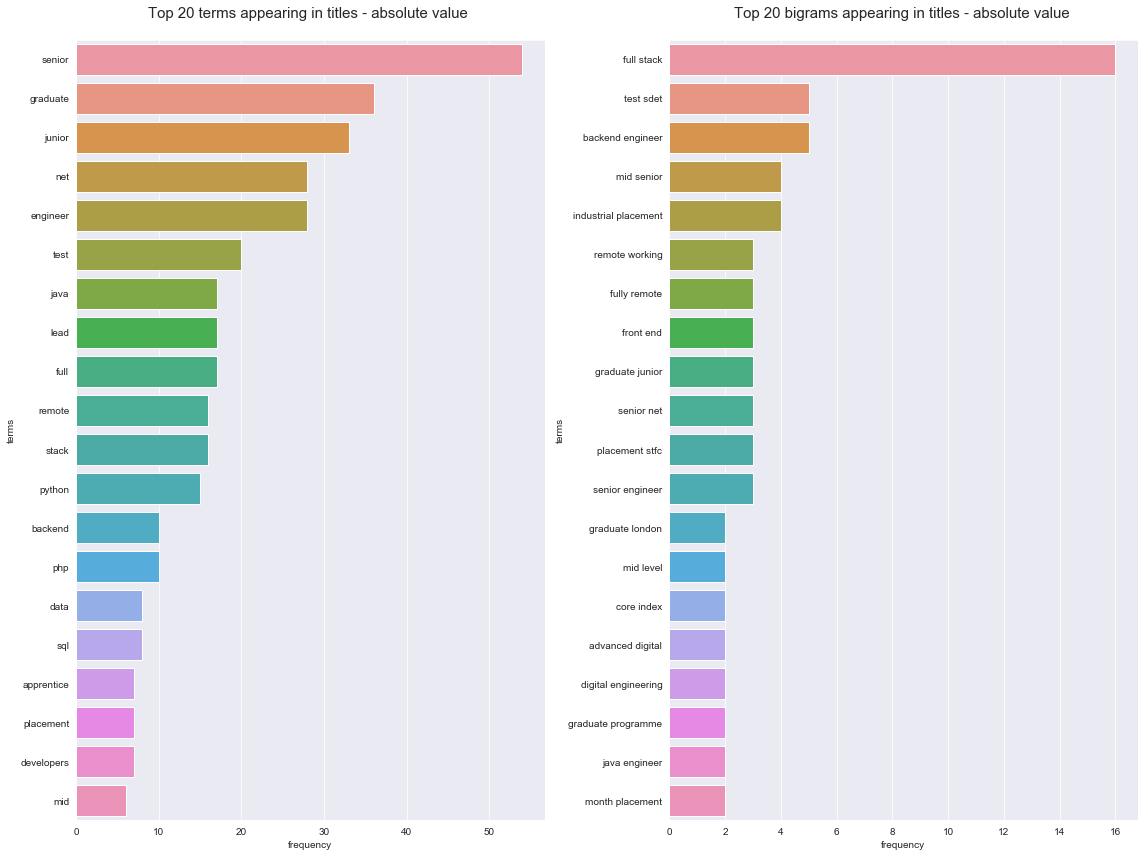

In [14]:
# plt.figure(figsize=(20,20))
fig, ax = plt.subplots(1,2, figsize=(16,12),  )

ax[0].set_title('Top {} terms appearing in titles - absolute value \n'.format(N), fontdict={'size':15})
ax[1].set_title('Top {} bigrams appearing in titles - absolute value \n'.format(N), fontdict={'size':15})
plt.rcParams['ytick.labelsize'] = 16
sns.barplot(data= title_df, x='frequency', y='terms', ax=ax[0], );
sns.barplot(data= title_df_bigram, x='frequency', y='terms', ax=ax[1]);
plt.tight_layout()
plt.savefig('fig/title_uni_and_bigrams.jpg')
plt.show()


## 5. Which programming languages are in greatest demand?
If we count the mention of languages across each of the job posts, we get the distribution in the graph below. 

I defined a list of major programming languages, looking for the 20 most popular ones, as based on the Q3 2020 Global Developer Population Calculator (available online through [SlashData](https://dashboard.slashdata.co/?utm_source=SlashData_Website&utm_medium=Header_Menu&utm_campaign=Calculator)).

In [175]:
# defining the list of programming languages to search for 
list_languages = [['Python', 'python'], 'Java',
                  ['JavaScript','Javascript', 'TypeScript', 'CoffeeScript'], #these 4 will be merged
                  'C++','C#', 'PHP', 'Swift', 'Kotlin', 'Ruby','Objective C', 
                  ['visual development', 'Visual development'], 
                  ['Shell', 'Shell script', 'Shell scripting', 'Bash',
                  'shell', 'shell script', 'shell scripting', 'bash'],   # note that these last 8 will be merged into 1
                 'Dart', 'Lua', 'Rust', 'Embedded C', 'Scala', 'Perl', 'SQL', '.NET'] 

In [176]:

new_df = fn.get_lang_count_and_store(df, list_languages, columns=['job_descr', 'job_title'])
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 0 to 499
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   company                               498 non-null    object 
 1   job_title                             498 non-null    object 
 2   job_descr                             498 non-null    object 
 3   time_of_scrape                        498 non-null    object 
 4   job_search_term                       498 non-null    object 
 5   salary_from_page_source_as_stated     243 non-null    float64
 6   salary_from_page_source_conv_hourly   243 non-null    float64
 7   salary_from_page_source_time_period   243 non-null    object 
 8   Num_reviews                           238 non-null    float64
 9   Loc_from_title                        498 non-null    object 
 10  date                                  498 non-null    object 
 11  states_salary      

In [177]:
new_df.tail(5)

,company,job_title,job_descr,time_of_scrape,job_search_term,salary_from_page_source_as_stated,salary_from_page_source_conv_hourly,salary_from_page_source_time_period,Num_reviews,Loc_from_title,...,num_mention_TOTAL_visual development,num_mention_TOTAL_Shell,num_mention_TOTAL_Dart,num_mention_TOTAL_Lua,num_mention_TOTAL_Rust,num_mention_TOTAL_Embedded C,num_mention_TOTAL_Scala,num_mention_TOTAL_Perl,num_mention_TOTAL_SQL,num_mention_TOTAL_.NET
495,Spectrum IT,Senior Software Developer - Client facing,Senior Software Developer client facing requir...,Fri Nov 20 11:33:07 2020,"title:(software , developer)",65000.0,34.25,Y,NaN,London,...,0,0,0,0,0,0,0,0,1,0
496,Reqiva Ltd,Lead software developer,This exciting new role Lead software developer...,Fri Nov 20 11:33:13 2020,"title:(software , developer)",70000.0,36.88,Y,NaN,Wokingham,...,0,0,0,0,0,0,0,0,1,0
497,Lawrence Harvey,Software Developer - .NET Developer,Software Developer Bishops Stortford 45k MVC a...,Fri Nov 20 11:33:18 2020,"title:(software , developer)",45000.0,23.71,Y,NaN,Bishop's Stortford,...,0,0,0,0,0,0,0,0,5,0
498,The Candidate,Lead Software Developer,Lead Software Developer eCommerce 60K Are you ...,Fri Nov 20 11:33:24 2020,"title:(software , developer)",60000.0,31.61,Y,2.0,Home Based,...,0,0,0,0,0,0,0,0,0,0
499,Oho Group,Software Developer,Software Developer Kernel Cyber Security Londo...,Fri Nov 20 11:33:29 2020,"title:(software , developer)",55000.0,28.98,Y,NaN,London,...,0,0,0,0,0,0,0,0,0,0


In [178]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498 entries, 0 to 499
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   company                               498 non-null    object 
 1   job_title                             498 non-null    object 
 2   job_descr                             498 non-null    object 
 3   time_of_scrape                        498 non-null    object 
 4   job_search_term                       498 non-null    object 
 5   salary_from_page_source_as_stated     243 non-null    float64
 6   salary_from_page_source_conv_hourly   243 non-null    float64
 7   salary_from_page_source_time_period   243 non-null    object 
 8   Num_reviews                           238 non-null    float64
 9   Loc_from_title                        498 non-null    object 
 10  date                                  498 non-null    object 
 11  states_salary      

In [179]:
language_counts = new_df.iloc[:,12:].sum(0, numeric_only=True)
language_counts.sort_values(ascending=False, inplace=True)
language_single_counts_ = new_df.iloc[:,12:]
language_single_counts_ = language_single_counts_.applymap(lambda x : 1 if (x>0) else 0,)
language_counts_uniq = language_single_counts_.sum(0, numeric_only=True)
language_counts_uniq.sort_values(ascending=False, inplace=True)
i, color_palette_dict = 0,{}
for lang in [x.replace('num_mention_TOTAL_', '') for x in language_counts_uniq.index]:
    color_palette_dict[lang] = f'C{i}'
    i= i+1
    
language_counts_disp = language_counts.loc[language_counts!=0]
language_counts_uniq_disp = language_counts_uniq.loc[language_counts_uniq!=0]

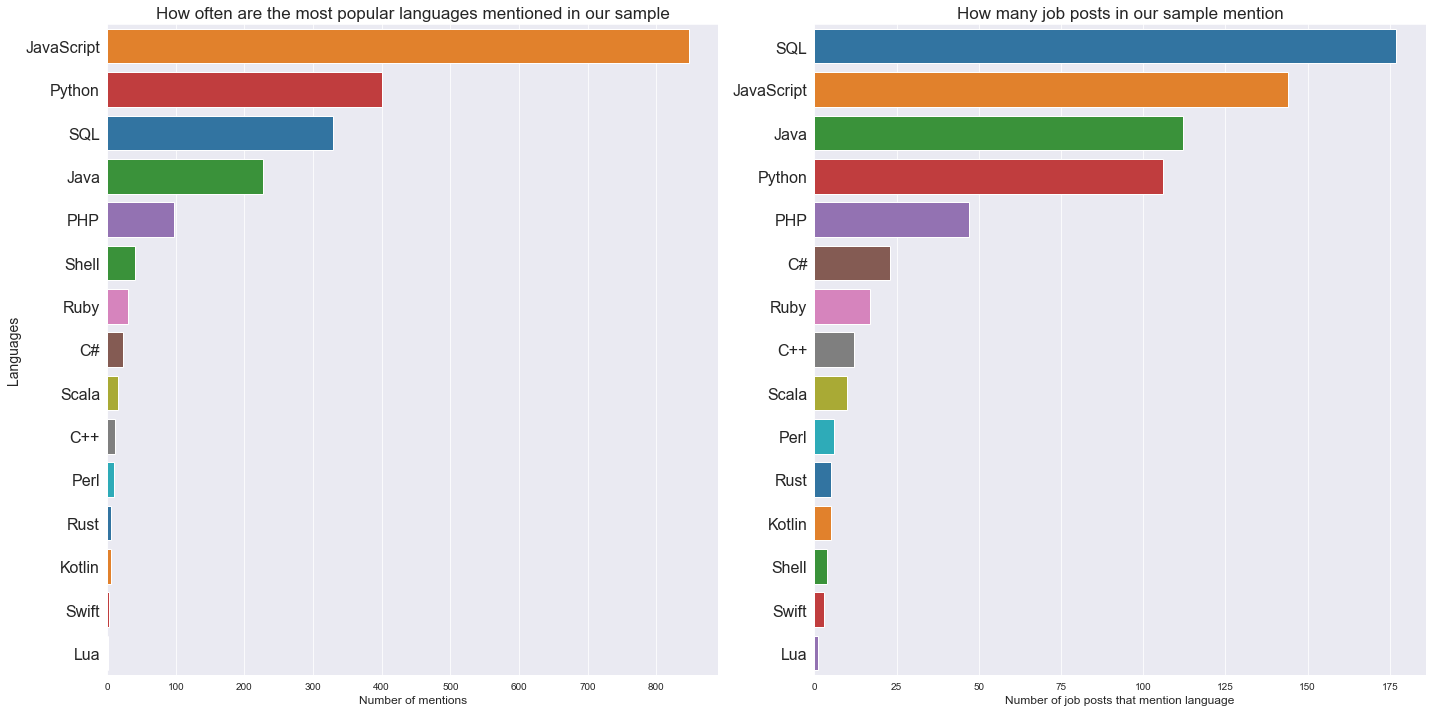

In [180]:
# plt.figure(figsize=(20,11))

fig, ax = plt.subplots(1, 2, figsize=(20,10))

sns.barplot(y = [x.replace('num_mention_TOTAL_', '') for x in language_counts_disp.index], x =language_counts_disp.values, orient='h', ax=ax[0], palette=color_palette_dict)
ax[0].set_title('How often are the most popular languages mentioned in our sample', fontdict={'size':17})
ax[0].set_xlabel('Number of mentions', fontdict={'size':12})
ax[0].set_ylabel('Languages', fontdict={'size':14})

sns.barplot(y = [x.replace('num_mention_TOTAL_', '') for x in language_counts_uniq_disp.index], x =language_counts_uniq_disp.values, orient='h', ax=ax[1], palette=color_palette_dict)
ax[1].set_title('How many job posts in our sample mention', fontdict={'size':17})
ax[1].set_xlabel('Number of job posts that mention language', fontdict={'size':12})
ax[1].set_ylabel('', fontdict={'size':14})
plt.tight_layout()
plt.savefig('fig/programming_languages.jpg')
plt.show()

### Testing for the association between the binary variable 

Given that we have a continuous/integer variable that we're interested in (salary) and we're testing it against binary variables (whether the specific programming language was mentioned or not), the ideal metric we'd like to use is the Point-Biserial Correlation. We'll be doing this for 5 different languages (the top 5 going by binary count - JavaScript to Ruby). We state an $\alpha$ of 0.05 and we correct that via Bonferroni Correction (which is a fancy way of saying we're going to divide our alpha by the number of tests we're doing) to 0.01.

*Note on salary data* : Given the number of assumptions being made at each step of data-mining (such as using regex to extract salaries based on, I used only salary data that had been stated as annual, for 2 reasons: this was by far the largest single block of salary types and this reduces the number of assumptions by 1, since a different regex pattern was used for the retrieval of each type of salary period. 

Key assumptions of Point-Biserial Correlation: 
1. A continuous variable and a dichotomous (binary) variable
2. No outliers in the salary for the subcategories (so no outliers in salary in either the group that did mention Java or the group that didn't)
3. Salary should be normally distributed for both subcategories of each binary variable
4. Salary should have equal variances for both subcategories of each binary variable

In the cell below I undertake the 3 necessary tasks for checking these assumptions are met:
* Plot boxplots of salary across all 10 subgroups (5 languages, Yes or No) - remove outliers if present
* Carry out Shapiro-Wilk test for normality on salary data for all subgroups - in this test the null hypothesis is that the data does come from a normal distribution. A p-value of less than our $\alpha$ of 0.01 means that we should not use that data
* Carry out Levene's test of equality of variances on each subgroup - similarly to Shapiro-Wilk test, we should only use the data when the p-value returned is larger

In [181]:
language_single_counts_salary = language_single_counts_.join(new_df[['salary_from_page_source_conv_hourly', 'salary_from_page_source_time_period']])
language_single_counts_salary = language_single_counts_salary.loc[language_single_counts_salary['salary_from_page_source_time_period']=='Y' ]
language_counts_binary = language_single_counts_salary[['num_mention_TOTAL_Python', 'num_mention_TOTAL_Java', 'num_mention_TOTAL_PHP', 'num_mention_TOTAL_JavaScript', 'num_mention_TOTAL_SQL', 'salary_from_page_source_conv_hourly']]
language_counts_binary = language_counts_binary.rename({'num_mention_TOTAL_Python':'mention_Python','num_mention_TOTAL_Java':'mention_Java','num_mention_TOTAL_PHP':'mention_PHP', 'num_mention_TOTAL_JavaScript':'mention_JavaScript (or variants)','num_mention_TOTAL_SQL':'mention_SQL'}, axis=1)

In [182]:
language_counts_binary.head()

,mention_Python,mention_Java,mention_PHP,mention_JavaScript (or variants),mention_SQL,salary_from_page_source_conv_hourly
0,0,0,0,0,0,84.30
1,0,0,0,0,0,42.15
2,0,1,0,0,1,17.91
4,0,0,0,0,0,11.78
5,1,1,1,1,1,33.46


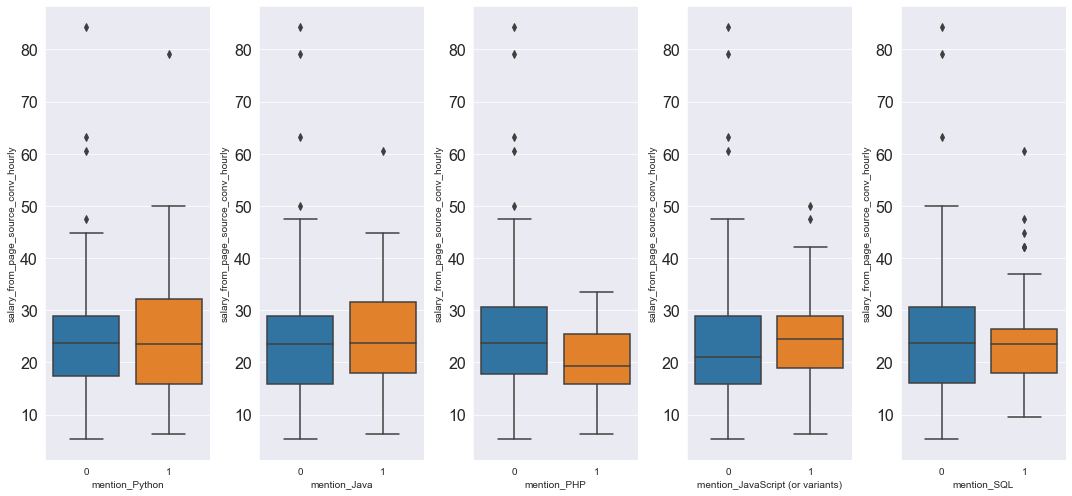

In [183]:
fig,ax = plt.subplots(1,5, figsize=(15,7))
for i, col in enumerate(language_counts_binary.columns[:5]):
    ax[i].set_xlabel(col)
    sns.boxplot(data=language_counts_binary, y = 'salary_from_page_source_conv_hourly', x=col, ax=ax[i])

plt.tight_layout()

Number of data points left after reduction is  217


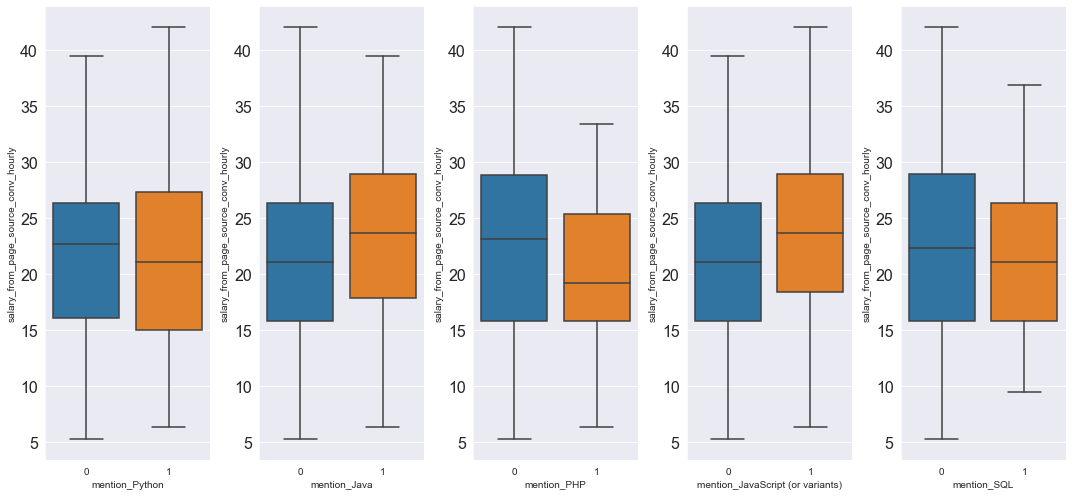

In [189]:
language_counts_binary_redu = language_counts_binary.loc[language_counts_binary.salary_from_page_source_conv_hourly< language_counts_binary.salary_from_page_source_conv_hourly.quantile(.95)]
print("Number of data points left after reduction is ", len(language_counts_binary_redu))
fig,ax = plt.subplots(1,5, figsize=(15,7))
for i, col in enumerate(language_counts_binary_redu.columns[:5]):
    ax[i].set_xlabel(col)
    sns.boxplot(data=language_counts_binary_redu, y = 'salary_from_page_source_conv_hourly', x=col, ax=ax[i])
    
plt.tight_layout()

From the test below, we will be discarding some subsets, namely the comparison across JavaScript and PHP, due to p-values below our alpha. Essentially we cannot use those distributions of data. 

In [192]:
from scipy.stats import shapiro
for i, col in enumerate(language_counts_binary_redu.columns[:5]):
    salary_non_mention = language_counts_binary_redu.loc[language_counts_binary_redu[col] == 0]['salary_from_page_source_conv_hourly']
    salary_did_mention = language_counts_binary_redu.loc[language_counts_binary_redu[col] == 1]['salary_from_page_source_conv_hourly']
    print("N for non-mention : ", len(salary_non_mention))
    print(f"Shapiro-Wilks test on salary distribution when var {col} = 0; p-value : ")
    print(shapiro(salary_non_mention)[1])
    print("N for did mention: ", len(salary_did_mention))
    print(f"Shapiro-Wilks test on salary distribution when var {col} = 1; p-value : ")
    print(shapiro(salary_did_mention)[1])
    print("\n")
    print("-"*100)

N for non-mention :  182
Shapiro-Wilks test on salary distribution when var mention_Python = 0; p-value : 
0.015292118303477764
N for did mention:  35
Shapiro-Wilks test on salary distribution when var mention_Python = 1; p-value : 
0.29100242257118225


----------------------------------------------------------------------------------------------------
N for non-mention :  178
Shapiro-Wilks test on salary distribution when var mention_Java = 0; p-value : 
0.022620510309934616
N for did mention:  39
Shapiro-Wilks test on salary distribution when var mention_Java = 1; p-value : 
0.5683718323707581


----------------------------------------------------------------------------------------------------
N for non-mention :  185
Shapiro-Wilks test on salary distribution when var mention_PHP = 0; p-value : 
0.007743345573544502
N for did mention:  32
Shapiro-Wilks test on salary distribution when var mention_PHP = 1; p-value : 
0.6568505167961121


---------------------------------------------

As we can see below, we have 2 subgroups that **do** meet our final assumption of equal variance. We can proceed with the final test on Python and Java.

In [193]:
language_counts_binary_redu_final = language_counts_binary_redu.drop(columns=['mention_JavaScript (or variants)', 'mention_PHP'])

from scipy.stats import levene
for i, col in enumerate(language_counts_binary_redu_final.columns[:3]):
    salary_non_mention = language_counts_binary_redu_final.loc[language_counts_binary_redu_final[col] == 0]['salary_from_page_source_conv_hourly']
    salary_did_mention = language_counts_binary_redu_final.loc[language_counts_binary_redu_final[col] == 1]['salary_from_page_source_conv_hourly']
    print(f"Levene test (for equal variances) on salary distribution for {col}; p-value:")
    print(levene(salary_non_mention, salary_did_mention)[1])
    print("\n")

Levene test (for equal variances) on salary distribution for mention_Python; p-value:
0.24528670278507406


Levene test (for equal variances) on salary distribution for mention_Java; p-value:
0.36517849344988995


Levene test (for equal variances) on salary distribution for mention_SQL; p-value:
0.002128690005710421




In [194]:
from scipy.stats import pointbiserialr

for i, col in enumerate(language_counts_binary_redu_final.columns[:2]):
    dichotomous_col = language_counts_binary_redu_final[col]
    continuous_col = language_counts_binary_redu_final['salary_from_page_source_conv_hourly']
    print(f"Point Biserial Coefficient test results between the dichotomous ({col}) var and the continuous (salary) var :")
    corr, pval = pointbiserialr(dichotomous_col, continuous_col)
    print("P-value     : ", pval)
    print("Correlation : ", corr)
    print("\n")


Point Biserial Coefficient test results between the dichotomous (mention_Python) var and the continuous (salary) var :
P-value     :  0.8696801700715007
Correlation :  -0.011201789743642679


Point Biserial Coefficient test results between the dichotomous (mention_Java) var and the continuous (salary) var :
P-value     :  0.4490789588152162
Correlation :  0.051649212912551756




So, to conclude this section - in our sample we found no significant associations between the presence of these specific languages we tested for and the salary for those jobs. 

 ## 6. What are the main topics emerging from the job descriptions?
 
Frequency distribution of words across these job descriptions is not the sharpest method we could use. Although it's interesting what comes out and see how it corresponds to insights from titles. Here's a few things to note:
* 
* 


In [32]:
%%capture

# using a lemmatizer to hopefully reduce the nr of unique but redundant words (e.g. condensing 'developer' and 'development' into 1 word)
lemmy = fn.LemmaTokenizer()
#How many terms to include
N=20

# putting software and developer into the list of stopwords - words we wish to ignore
special_sw = fn.gen_stopwords(['software', 'developer', 'permanentsalary', 'yearbenefits']) #adding the last two as they have come up as frequent typos
descr = df.job_descr.dropna()
descr_term_df = fn.get_top_n_terms(descr, N, stop_words_list=special_sw, tokenizer_obj=lemmy)
descr_bigram_df = fn.get_top_n_terms(descr, N, stop_words_list=special_sw , ngram_number=2, tokenizer_obj=lemmy)
descr_trigram_df = fn.get_top_n_terms(descr, N, stop_words_list=special_sw , ngram_number=3, tokenizer_obj=lemmy)

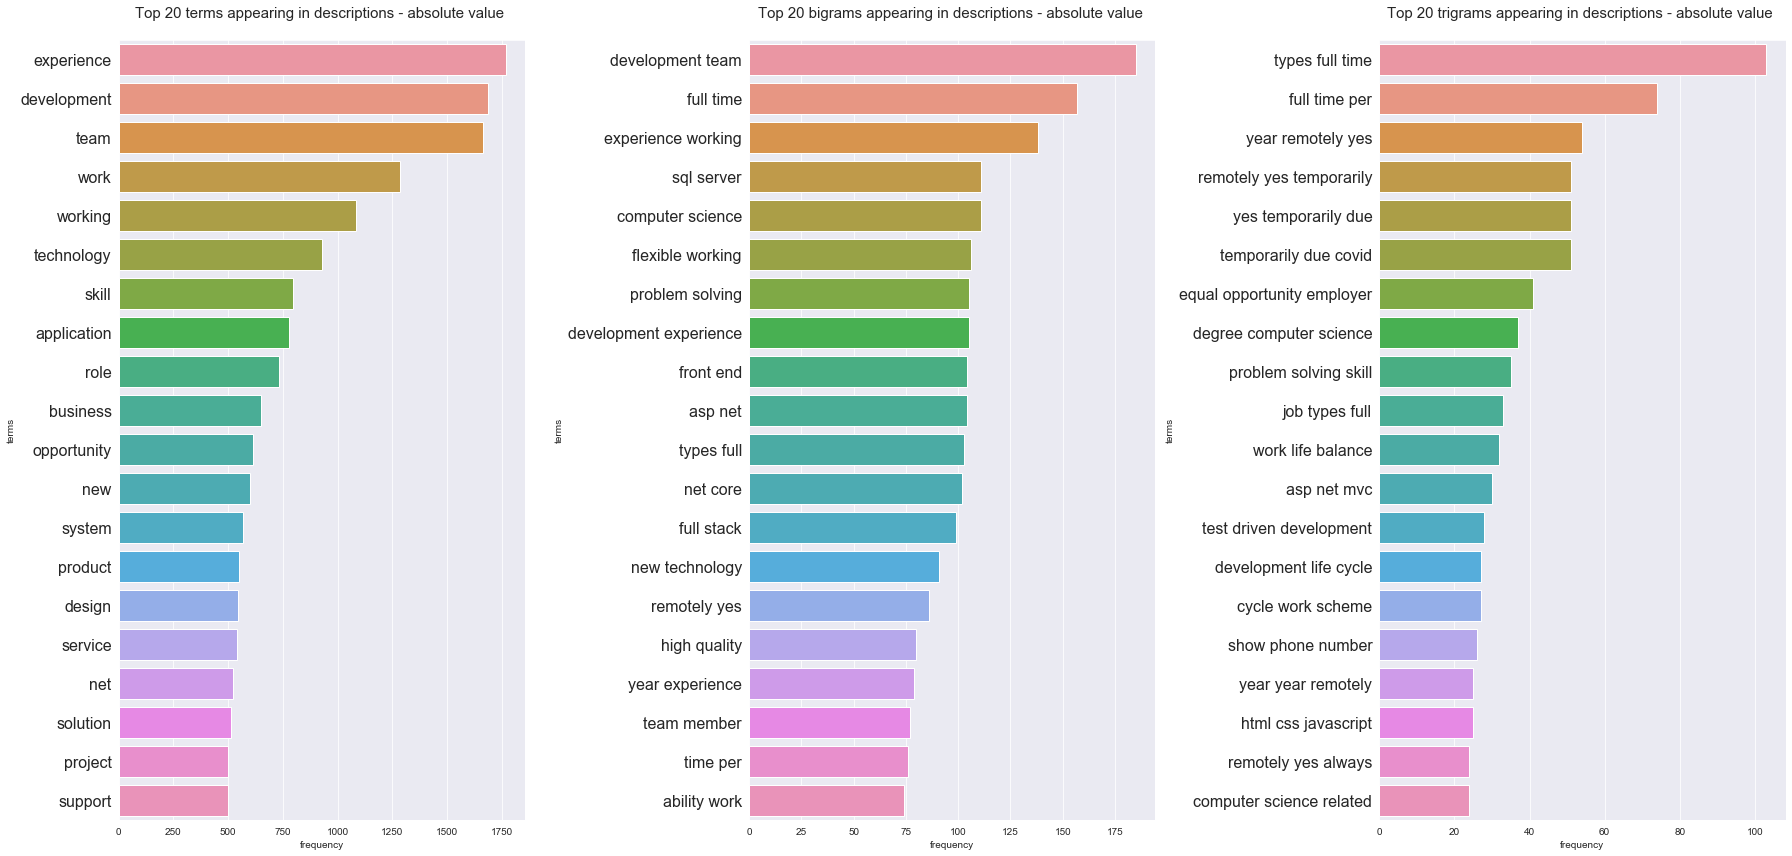

In [33]:
# plt.figure(figsize=(20,20))
fig, ax = plt.subplots(1,3, figsize=(25,12),  )

ax[0].set_title('Top {} terms appearing in descriptions - absolute value \n'.format(N), fontdict={'size':15})
ax[1].set_title('Top {} bigrams appearing in descriptions - absolute value \n'.format(N), fontdict={'size':15})
ax[2].set_title('Top {} trigrams appearing in descriptions - absolute value \n'.format(N), fontdict={'size':15})

plt.rcParams['ytick.labelsize'] = 16
sns.barplot(data= descr_term_df, x='frequency', y='terms', ax=ax[0])
sns.barplot(data= descr_bigram_df, x='frequency', y='terms', ax=ax[1])
sns.barplot(data= descr_trigram_df, x='frequency', y='terms', ax=ax[2]);

plt.tight_layout()

The real insights however, can emerge when we run topic modelling on this corpus: that will deliver far more results. 

In [38]:
%%time

number_topics = 10

count_vect_lem = CountVectorizer(tokenizer=fn.LemmaTokenizer(),
                       strip_accents = 'unicode',
                       stop_words = special_sw,
                       lowercase = True,)

lda = LDA(n_components=number_topics,
          doc_topic_prior = 1,
          topic_word_prior = 0.05,
          n_jobs=-1, random_state=12345)



lda_data, lda_obj = topic.data_to_lda(df, 12, 'job_descr', count_vect_lem, lda, )

CPU times: user 1.78 s, sys: 484 ms, total: 2.26 s
Wall time: 3.58 s


If you're interacting with the pyLDAvis plot below, I recommend setting the lambda slider between 0.4 and 0.6, as the optimal value for getting insights into the metric.

In [39]:
%%time
pyLDAvis.enable_notebook()

display_data = pyLDAvis.sklearn.prepare(lda_obj, 
                         count_vect_lem.fit_transform(df['job_descr']),
                        count_vect_lem,)
pyLDAvis.display(display_data)

CPU times: user 5.38 s, sys: 80 ms, total: 5.46 s
Wall time: 7.23 s


In [40]:
pyLDAvis.save_html(display_data, 'LDA_viz_plot.html')

What are the emergent topics then? Can we assing them some kind of names based on most relevant terms that come up for them? 
With unsupervised learning such as this, we must err on the side of caution and remember that a lot of noise is surfacing amongst the seemingly useful data. With that in mind:
* Topic 1 - *HRSpeak* - the largest topic by far (in terms of number of tokens it encompasses), contains a lot of noise - words such as "work", "team", "experience" - this a topic we would expect to appear in most if not all of the job posts and offers little to no useful information.
* Topic 2 - *General software development* - overlaps with Topic 1 in a lot of terms, but has a more technical bent to it (terms range from "business", "role" to "asp", "sql" and "javascript".
* Topic 3 - once again, a noisy topic, judging by the low ratio of estimated term frequencies vs overall frequencies. 
* Topic 4 - *Computer Architecture focus* - the terms with the highest conditional topic distribution are all centred around computer architecture or cluster computing - spark, apache, arm. Terms such as "health(care)" and "nuance" are not however noise - there is a company in our dataset called Nuance, an AI Healthcare organisation. We'll have to check just how much of these jobs are dominating this topic.
* Topic 5 - *Academic & Scientific comps* - a small group of jobs that are probably centred around the UK's two leading universities and involve contributing to scientific research (will show examples later).
* Topic 6 - *Finance and quant trading* - SE roles focussed on building and optimising software for banks and for trading.


After topic 6 onwards the clusters become really small and we should be extra cautious in drawing any conclusions from these.

In [42]:
fn.preview_topic_jobs(lda_data, topic_col = 'topic_4', num_jobs=4)

Job title: -  PHP Software Developer 

Company: -  PureNet Solutions
Location (from title): -  York
Job salary: -  nan


are currently seeking PHP Software Developer join our established Magento Software Engineering team This role would suitable for candidate who ha year experience web development PHP framework Zend Magento WordPress any other PHP framework Reporting the Technical Manager the ideal candidate will have experience software architecture and technical development process building web application You will given the opportunity Magento Certified Developer and increase your about Magento You will increase your and experience building eCommerce website using Magento working with certified Magento Developers envisaged that you will promoted Magento Developer within month Benefits Free parking 10am birthday start subsidised snack shop team event pension option day leave excluding bank holiday Start Date June July 2019 Key responsibility code project Peer created other team membe

In [45]:
fn.preview_topic_jobs(lda_data, 'topic_5', num_jobs=5)

Job title: -  Software Developer 

Company: -  Guardian News & Media
Location (from title): -  London
Job salary: -  nan


Here The Guardian believe the open exchange information idea and opinion ha the power change the world for the better More people than ever before are reading watching and listening Guardian journalism from across the world Over the past year The Guardian achieved digital traffic with our highest number regular reader and monthly page view averaging over billion 2019 hit our highest revenue decade and achieved the goal set three year earlier break even now path achieve the goal two million people supporting The Guardian 2022 are recruiting Software Developer join our exciting digital team for month fixed About the role You mostly programming Scala running AWS but use the tool that best fit the solution You working cross functional team which empowered iterate and release new feature You won isolation our culture whether pair programming with other developer working

In [44]:
fn.preview_topic_jobs(lda_data, 'topic_6', 5)


Job title: -  Market Data Software Developer 

Company: -  London Stock Exchange Group
Location (from title): -  London
Job salary: -  nan


Market Data Developer LCH Role Profile Background The Market Data system used LCH manage and maintain the majority the instrument market data and reference data used The base product based off Asset Control which third party application The system built Asset Control functionality well Perl Python Shell scripting and Java also used drive some process Control which third party application GIT used the tool along with Bamboo and Bladelogic manage our deployment and package build which are third party application Role The role will build enhancement and project requirement using base product were possible However there will element development set other language Continuous integration testing will also part the development life cycle The successful candidate expected self starter team player adaptable with shell scripting experience KEY RESPONSIBILIT